In [18]:
using SciBmad, CairoMakie
import DifferentiationInterface as DI

In [19]:
include("../lattices/esr-v6.3.1.jl");

Let's set the RF voltage for $Q_s=-0.05$

In [20]:
# To use SciBmad's newton search function, need to create a function 
# val_and_jac!(y, jac, x, params) which mutates in place y=f(x) and 
# jac with the jacobian at point x. p is a set of parameters 
# which will can be modified in the function call. note y should
# be residual
function val_and_jac!(y, jac, x, ps)
    lat = ps[1]
    cavities = ps[2]
    descriptor = ps[3]
    Δv = vars(descriptor)
    Δk = params(descriptor)[1]
    for cav in cavities
        cav.voltage= x[1] + Δk
    end
    v0, __ = find_closed_orbit(lat; backend=DI.AutoGTPSA(descriptor), prep=nothing, prep_coast=nothing)
    b0 = Bunch(v0 + Δv; species=lat.species_ref, R_ref=lat.R_ref)
    track!(b0, lat)
    m = DAMap(v=b0.coords.v)
    a = normal(m)
    c = c_map(a)
    r = inv(c) ∘ inv(a) ∘ m ∘ a ∘ c
    Qs = real(-log(SciBmad.NNF.factor_out(r.v[5], 5))/(2*pi*im))
    y[1] = scalar(Qs) + 0.05
    jac[1] = Qs[7]
end

# We will use GTPSA to get the gradient
# Then use a newton search with that gradient
# Need 6 variables (2nd order) and 1 parameter (1st order)
cavities = ring.line[findall(x->x.kind=="RFCavity", ring.line)];
descriptor = Descriptor(6, 2, 1, 1)
y = [0.0]
jac = [0.0]
x = [4e6]
@time res = SciBmad.newton!(val_and_jac!, y, jac, x, (ring, cavities, descriptor))

  3.059375 seconds (49.72 M allocations: 4.565 GiB, 9.62% gc time, 0.85% compilation time: 100% of which was recompilation)


(u = [3.355606790694894e6], converged = true, n_iters = 5)

In [21]:
# load new lattice bc new TPSA, set with proper synch tune
include("../lattices/esr-v6.3.1.jl");
cavities = ring.line[findall(x->x.kind=="RFCavity", ring.line)];
foreach(x->x.voltage=res.u[1], cavities)
# Check
t = twiss(ring);
t.phi_3[end]

-0.049999999999994375

In [22]:
# Turn on radiation damping
foreach(x->x.tracking_method=Yoshida(order=2, radiation_damping_on=true), ring.line)

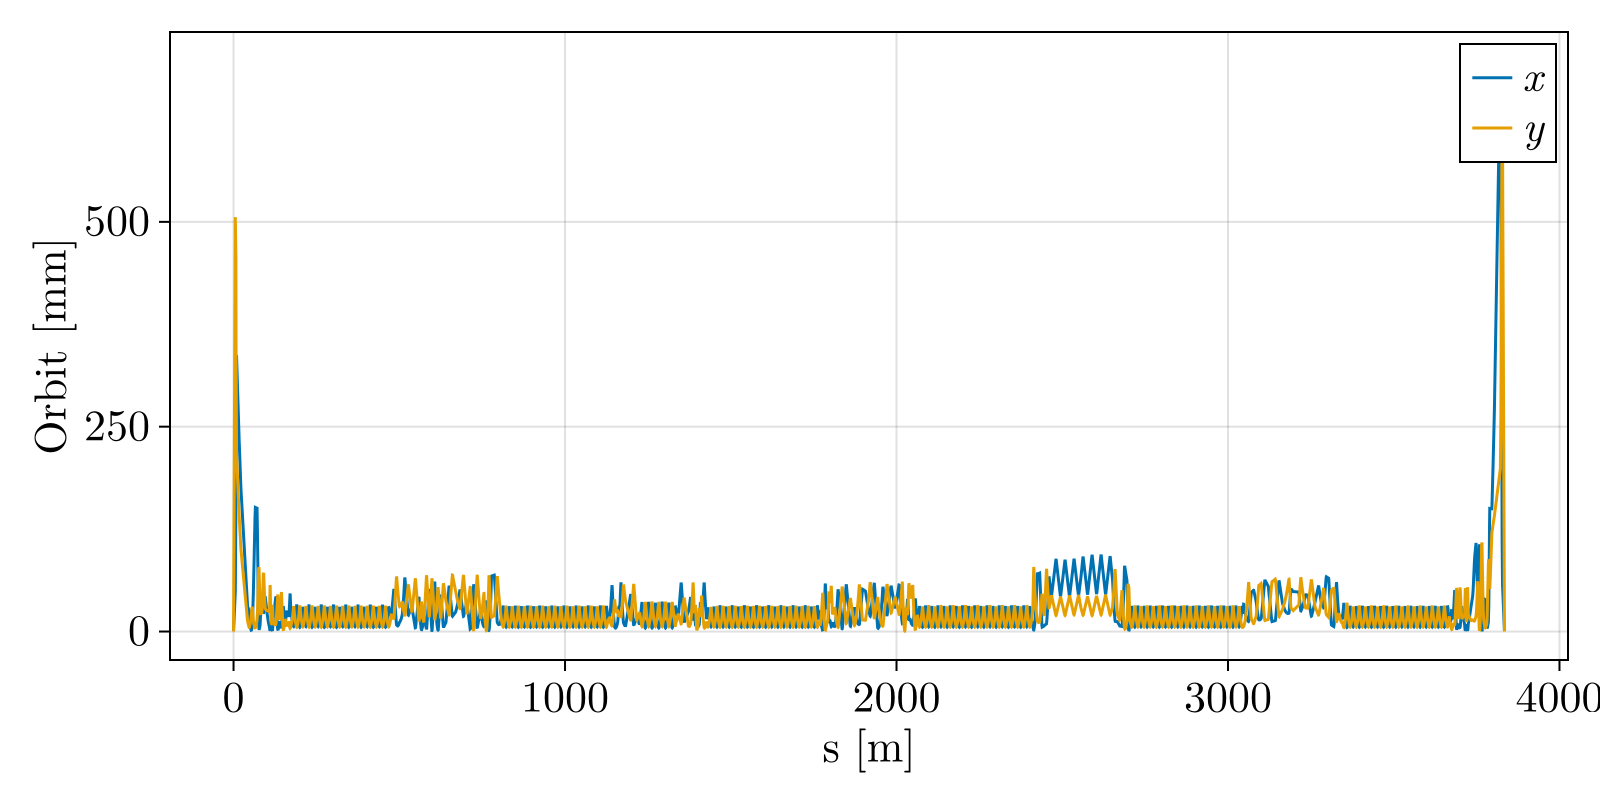

In [25]:
# Plot the orbit:
t = twiss(ring)
set_theme!(theme_latexfonts())

f = Figure(fontsize=22, size=(800,400));
ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Orbit [mm]");
lines!(ax, t.s, t.beta_1, label=L"x"); 
lines!(ax, t.s, t.beta_2, label=L"y");
axislegend(position=:rt);
display(f);

In [24]:
sols_idx = findall(x->x.kind=="Solenoid", ring.line)
foreach(x->println(x.name), ring.line[sols_idx])

HSOL20_6
HSOL20_6
HSOL20_6
HSOL20_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL5_6
HSOL20_6
HSOL20_6
HSOL20_6
HSOL20_6


In [ ]:
end_sol_idx = sols_idx[8]
start_sol_idx = sols_idx[9]
dual_planes = 